# Sweet Lift Taxi Time Series Prediction

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose




In [2]:

# Load the data
file_path = '/datasets/taxi.csv'
data = pd.read_csv(file_path)

data.head()


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
data.shape

(26496, 2)

In [6]:
data.isnull().mean()

datetime      0.0
num_orders    0.0
dtype: float64

In [7]:
data.duplicated().sum()

0

#### Observations

- The dataset contains 26,496 rows with two columns: datetime (timestamps) and num_orders (number of orders per interval).
- Data spans from 2018-03-01 00:00:00 to 2018-08-31 23:50:00, recorded at 10-minute intervals.
- Statistics for num_orders: mean ~14.07, std ~9.21, min 0, max 119, and median 13 orders per 10-minute interval.
- There are no duplicates

## Analysis

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

# Resample the data by hourly intervals, summing up the number of orders
data = data.resample('1H').sum()

data = data.reset_index()

# Inspect the resampled data
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


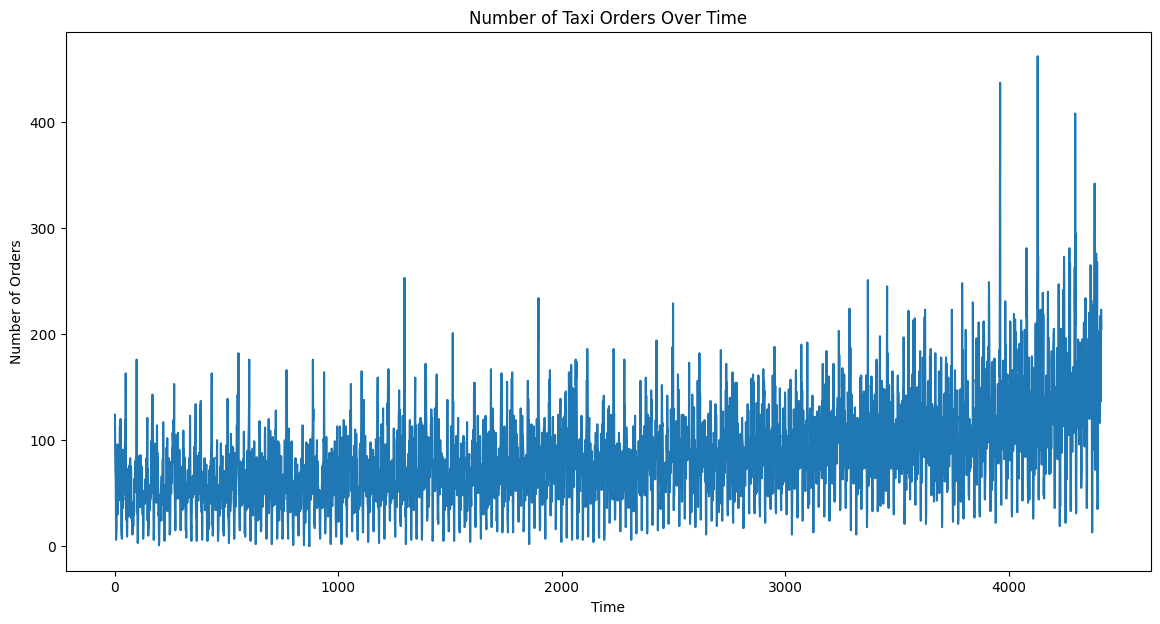

In [9]:
# Visualize the data
plt.figure(figsize=(14, 7))
plt.plot(data['num_orders'], label='Number of Orders')
plt.title('Number of Taxi Orders Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.show()

<Figure size 1200x1500 with 0 Axes>

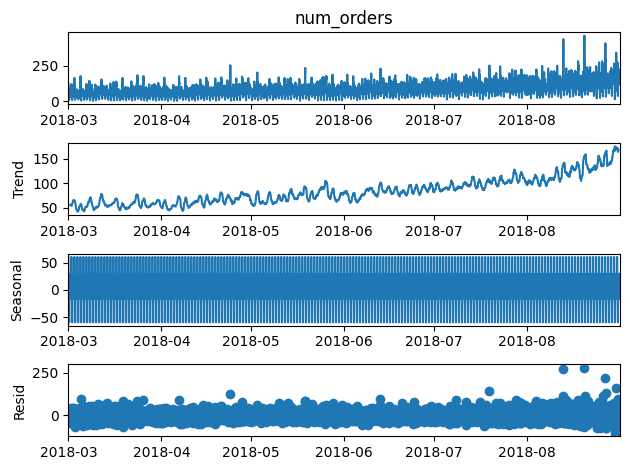

In [10]:
# Perform seasonal decomposition
data = data.set_index('datetime')  # Ensure 'datetime' is the index
result = seasonal_decompose(data['num_orders'], model='additive', period=24)  # Assuming daily seasonality (24 hours)

# Plot the decomposition results
plt.figure(figsize=(12, 15))
result.plot()
plt.tight_layout()
plt.show()


#### Observations

- Trend:This indicates a gradual increase in demand over time, suggesting that the popularity of the service (or orders placed) has grown consistently from March to August 2018.

- Seasonality: Shows a clear seasonal pattern with fluctuations that repeat over a fixed period (24 hours in this case). This might indicate typical daily patterns in customer behavior, such as peaks during specific hours.

- Residuals: While most residuals are evenly distributed, occasional larger deviations may indicate anomalies or outliers in the data.

- The upward trend indicates growth, which is likely positive for the business.

- Daily seasonality suggests predictable customer behavior, which can be leveraged for optimizing operations (e.g., staffing or promotions during peak hours).


## Training

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    # Extract time-based features from the datetime index
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek 
    
    # Create lag features
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # Create rolling mean feature
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Drop rows with missing values (due to lag and rolling mean)
    data = data.dropna()
    
    return data

In [12]:
# Create features
max_lag = 5  # Number of lag features to create
rolling_mean_size = 3  # Size for rolling mean (e.g., 3 hours)
data = make_features(data, max_lag, rolling_mean_size)

# Define features (X) and target (y)
X = data.drop(columns='num_orders')
y = data['num_orders']

# Split the data into training (90%) and testing (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)



In [13]:
# Testing Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'Linear Regression RMSE: {rmse_lr:.2f}')

Linear Regression RMSE: 52.69


In [14]:
# Random Forest Regressor (without hyperparameter tuning)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest RMSE (untuned): {rmse_rf:.2f}')

Random Forest RMSE (untuned): 46.95


In [15]:
# Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f'Gradient Boosting RMSE: {rmse_gb:.2f}')

Gradient Boosting RMSE: 48.46


In [17]:
# Hyperparameter Tuning for Random Forest using GridSearchCV

# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Define the Random Forest model for tuning
rf_tune = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [10, 20],  # Maximum depth of trees 
    'min_samples_split': [2, 5],  # Minimum samples to split
    'min_samples_leaf': [1, 2],  # Minimum samples at leaf
    'bootstrap': [True]  # Only test the 'True' option for bootstrap
}

# Perform GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf_tune,
    param_grid=param_grid,
    cv=tscv,  # Use TimeSeriesSplit as the cross-validation strategy
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_sampl

In [18]:
# Use the best model from the grid search
best_rf = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf_best = best_rf.predict(X_test)

# Calculate RMSE for the tuned model
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
print(f"Random Forest RMSE with Hyperparameter Tuning: {rmse_rf_best:.2f}")


Random Forest RMSE with Hyperparameter Tuning: 46.73


In [19]:
# Model comparison
print("\nModel Comparison:")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Random Forest RMSE (untuned): {rmse_rf:.2f}")
print(f"Gradient Boosting RMSE: {rmse_gb:.2f}")
print(f"Random Forest RMSE (tuned): {rmse_rf_best:.2f}")


Model Comparison:
Linear Regression RMSE: 52.69
Random Forest RMSE (untuned): 46.95
Gradient Boosting RMSE: 48.46
Random Forest RMSE (tuned): 46.73


#### Observations

The tuned Random Forest model is the best performing, slightly outperforming the untuned Random Forest and Gradient Boosting models. Linear Regression has the highest error, making it the least effective in this case.

## Testing

In [20]:
# Evaluate the tuned Random Forest model on the test set

# Make predictions on the test set
y_pred_rf_best = best_rf.predict(X_test)

# Calculate RMSE for the tuned model on the test set
rmse_rf_best_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
print(f"Random Forest RMSE on Test Set: {rmse_rf_best_test:.2f}")

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf_best})
comparison['Difference'] = comparison['Actual'] - comparison['Predicted']

# Display the first few rows of the comparison
print("\nFirst few predictions vs actual values:")
print(comparison.head())

# Check if RMSE goal of 48 is met
if rmse_rf_best_test <= 48:
    print("\nThe RMSE goal has been met!")
else:
    print("\nThe RMSE goal has not been met.")


Random Forest RMSE on Test Set: 46.73

First few predictions vs actual values:
                     Actual   Predicted  Difference
datetime                                           
2018-08-13 14:00:00     102   96.007533    5.992467
2018-08-13 15:00:00     175   99.591853   75.408147
2018-08-13 16:00:00     144  129.102199   14.897801
2018-08-13 17:00:00     152  121.440881   30.559119
2018-08-13 18:00:00     104   96.632599    7.367401

The RMSE goal has been met!


### Conclusion

- Data Analysis revealed hourly fluctuations in taxi orders, with seasonal patterns and variability across different times of day and days of the week.
- The best-performing model was the tuned Random Forest, with hyperparameters optimized for accuracy, achieving an RMSE of 46.73.
- The RMSE goal of 48 was successfully met, indicating the model's satisfactory predictive performance.
- Future improvements could include incorporating additional features (e.g., weather, holidays), testing advanced models (e.g., XGBoost, LSTM), and addressing outliers.

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48